In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv
/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv


# About the dataset

We will be creating a prediction model that not only helps the applicant to find out if they are eligible for the loan , but also helps the bank by minimizing the risk and reducing the number of defaulters.

We have been provided with below applicant information based on which prediction is to be made whether the applicant's loan request can be approved or not

1. Loan ID
2. Gender- Male or Female
3. Married - Whether the applicant is married or unmarried
4. Dependents - How many dependents does applicant have
5. Education- whether the applicant is graduate or non graduate
6. Self Employed - whether he is self employed or not
7. Applicant income 
8. CoApplicant income 
9. Loan Amount - 
10. Loan Amount term
11. Credit History
12. Property Area
13. Loan status

**Task : Predict whether an appplicants loan request can be approved or not** 

# Loading the dataset

In [2]:
train=pd.read_csv("/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv')

#Creating a copy for backup
train_og=train.copy()
test_og=test.copy()

# Loading packages

In [3]:
#Visualisation Library
import seaborn as sns
import matplotlib.pyplot as plt

#To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

#Classification model 
from sklearn.linear_model import LogisticRegression

#Classification model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#To split the model into training and testing data
from sklearn.model_selection import train_test_split

#Different model improvement packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Evaluation metrics
from sklearn import metrics

In [4]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
test.columns #we can observe that the loan status column is missing which needs to be predicted

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [6]:
#Checking the data types of our data
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

* All the object data types needs to be converted into int so we can build a model 
* Dependents has to be int which has to be looked into

In [7]:
#Checking the number of rows and columns in our dataset
train.shape,test.shape

((614, 13), (367, 12))

In [8]:
#Checking the bal of target variable
train["Loan_Status"].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

* There isnt a good bal between our target which needs to be managed using ROS method or stratify

# Visualising Categorical variables

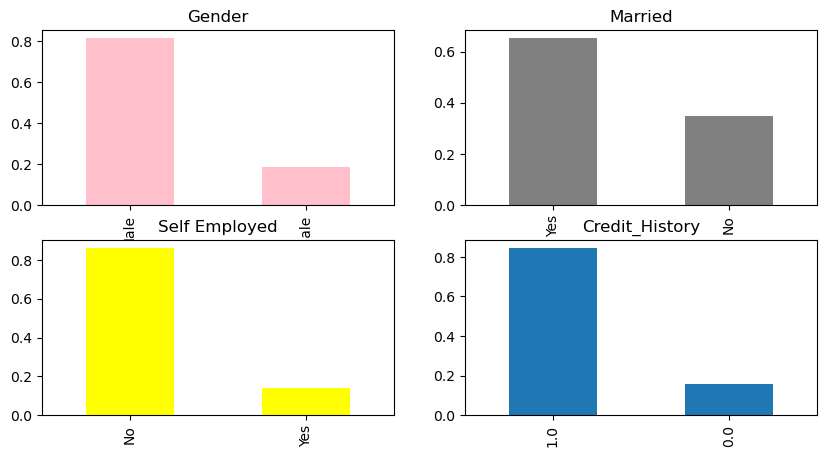

In [9]:
plt.figure(1) 
plt.subplot(2,2,1)
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Gender',color='pink')
plt.subplot(2,2,2)
train['Married'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Married',color='grey')
plt.subplot(2,2,3)
train['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Self Employed',color='yellow')
plt.subplot(2,2,4)
train['Credit_History'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Credit_History')
plt.show()

Most loan Applicants are male, married and not self_employed with a 1.0 credit history

# Visualising Ordinal Variable

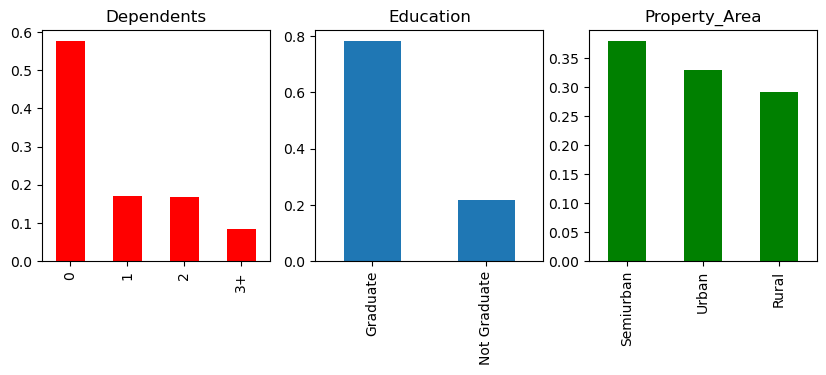

In [10]:
plt.figure(1)
plt.subplot(1,3,1)
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Dependents',color='red')
plt.subplot(1,3,2)
train['Education'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Education')
plt.subplot(1,3,3)
train['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Property_Area',color='green')
plt.show()

Most applicants dont have dependents are graduates and belong from semiurban area

In [11]:
train['Dependents']=train['Dependents'].replace('3+','3')

# Visualising Numeric Variables and checking for outliers

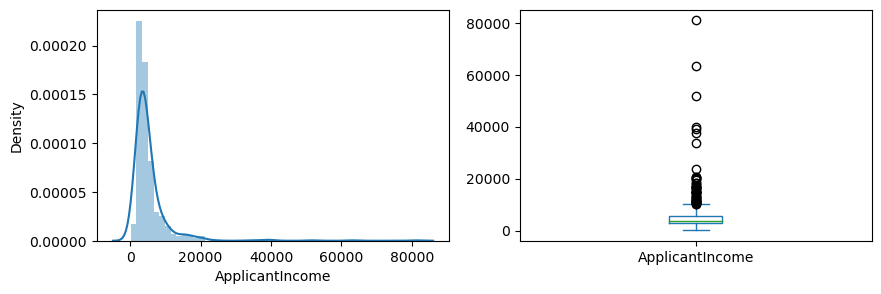

In [12]:
plt.figure(1)
plt.subplot(1,2,1)
sns.distplot(train['ApplicantIncome'])
plt.subplot(1,2,2)
train['ApplicantIncome'].plot.box(figsize=(10,3))
plt.show()

We can observe that there is high left skewness in the applicant income which means there are outliers which needs to be treated before we build our model

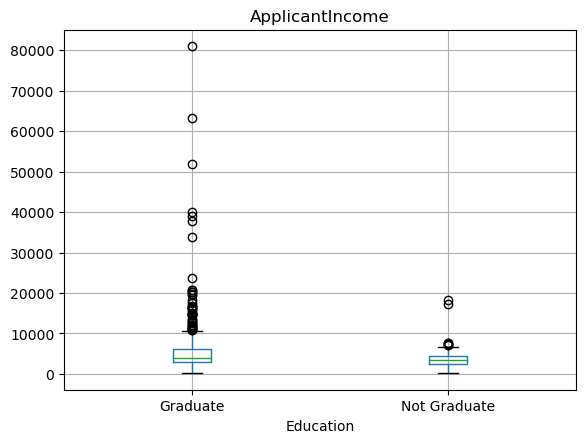

In [13]:
#Visualizing the application income considering whether applicant is graduate or not
train.boxplot(column='ApplicantIncome',by='Education')
plt.suptitle("")
plt.show()

We can observe that most anomalies are in case of Graduates compared to non graduates

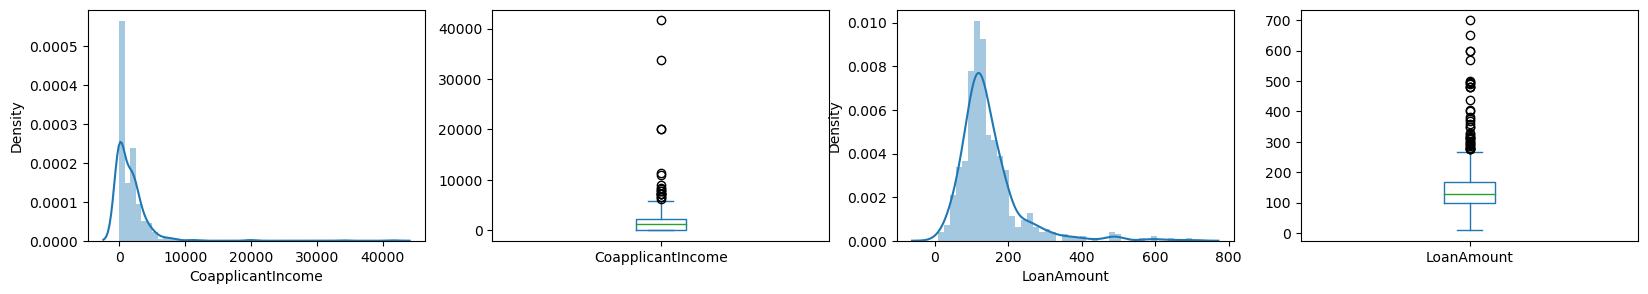

In [14]:
plt.figure(1)
plt.subplot(1,4,1)
sns.distplot(train['CoapplicantIncome'])
plt.subplot(1,4,2)
train['CoapplicantIncome'].plot.box(figsize=(20,3))
plt.subplot(1,4,3)
sns.distplot(train['LoanAmount'])
plt.subplot(1,4,4)
train['LoanAmount'].plot.box()
plt.show()

Theres high skewnesss for coapplicant income and light skewness in case of loan amount

# Bivariate Analysis

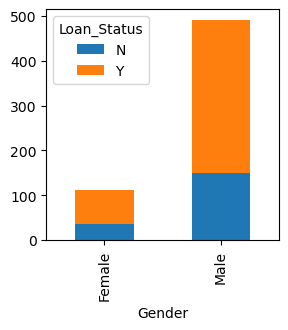

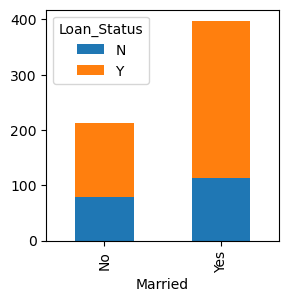

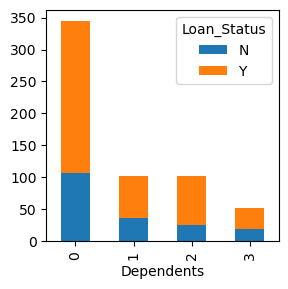

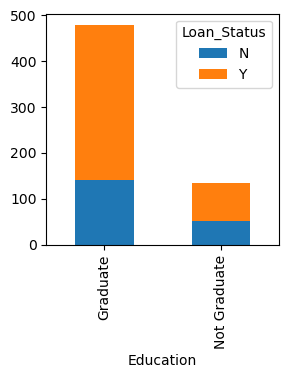

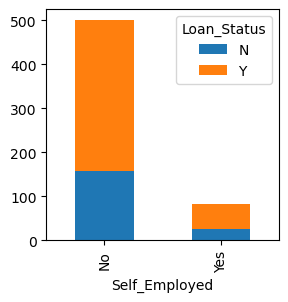

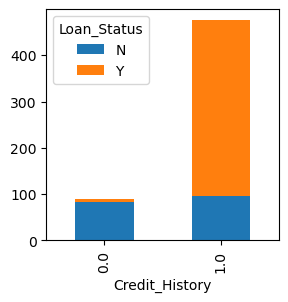

In [15]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.plot(kind='bar',stacked=True,figsize=(3,3))

married=pd.crosstab(train['Married'],train['Loan_Status'])
married.plot(kind='bar',stacked=True,figsize=(3,3))

dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.plot(kind='bar',stacked=True,figsize=(3,3))

education=pd.crosstab(train['Education'],train['Loan_Status'])
education.plot(kind='bar',stacked=True,figsize=(3,3))

selfemployed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
selfemployed.plot(kind='bar',stacked=True,figsize=(3,3))

credithistory=pd.crosstab(train['Credit_History'],train['Loan_Status'])
credithistory.plot(kind='bar',stacked=True,figsize=(3,3))

plt.show()

* From the above visualisation its clear that mostly graduates, self-employed and applicants with 0 dependents have high chances of loan approval
* Applicants whose credit history is 0 have very low chances of getting loan

# Correlation of dataset

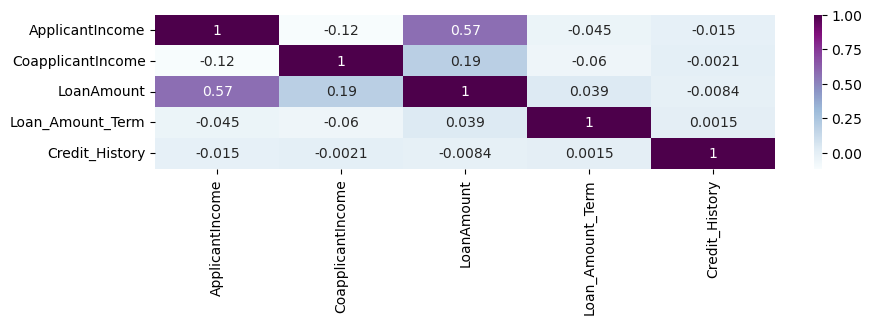

In [16]:
plt.figure(figsize=(10,2))
sns.heatmap(train.corr(),cmap='BuPu',annot=True)
plt.show()

# Missing Value Imputation

In [17]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [18]:
#Creating variables that stores all numeric and object columns
numeric_col= train.select_dtypes([int,float]).columns
object_col= train.select_dtypes([object]).columns
print('object columns: ', object_col)
print('numeric columns:' , numeric_col)

object columns:  Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')
numeric columns: Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


In [19]:
#Inputing the missing numeric data with mean value
for i in train[numeric_col]:
    print(i,':' ,round(train[i].mean(),2))
    train[i].fillna(round(train[i].mean(),2),inplace=True)

ApplicantIncome : 5403.46
CoapplicantIncome : 1621.25
LoanAmount : 146.41
Loan_Amount_Term : 342.0
Credit_History : 0.84


In [20]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

All the numeric missing values have been imputed 

In [21]:
#Imputing object data with mode
for i in train[object_col]:
    print(i,':', train[i].mode()[0])
    train[i].fillna(train[i].mode()[0],inplace=True)

Loan_ID : LP001002
Gender : Male
Married : Yes
Dependents : 0
Education : Graduate
Self_Employed : No
Property_Area : Semiurban
Loan_Status : Y


In [22]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

NO more missing values 

# Understanding the uniqueness of our data

In [23]:
#Checking the uniquness of our data
train.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
Loan_Status            2
dtype: int64

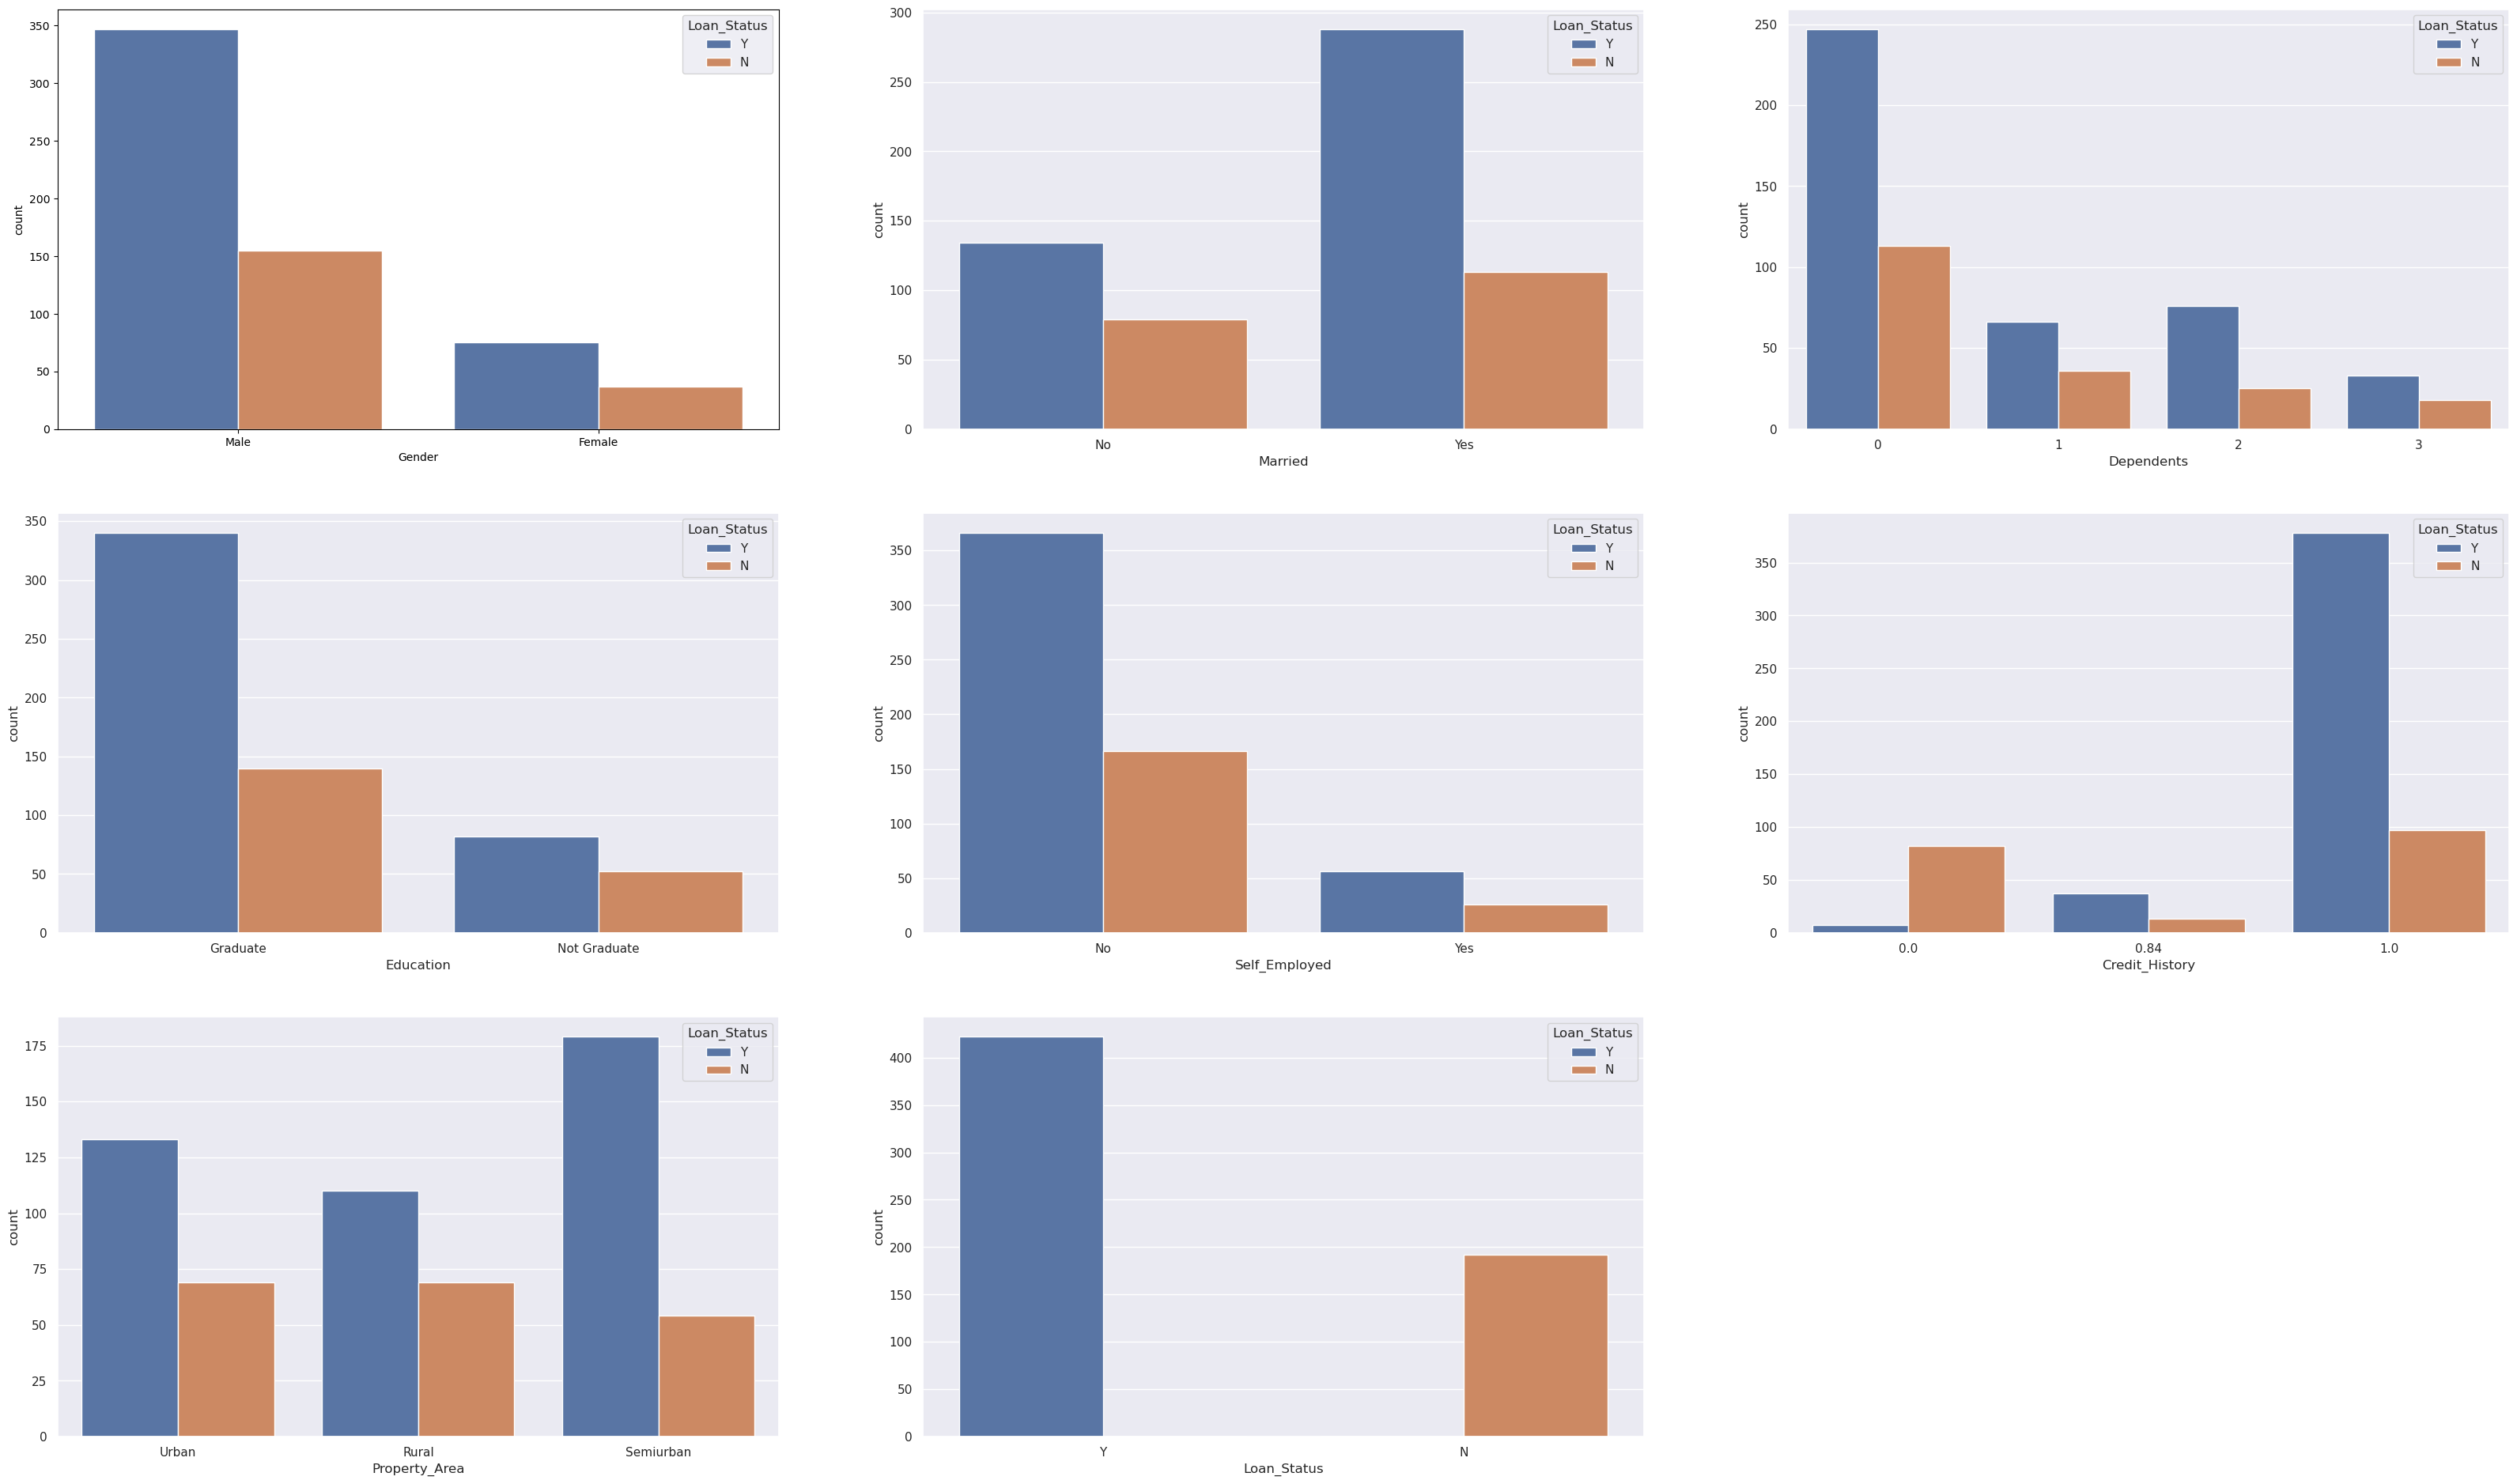

In [24]:
#Visualising features with low unique values for better understanding
v= train[['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area' \
          ,'Loan_Status']].columns
plt.figure(figsize=(40,40))
for i,col in enumerate(v):
    plt.subplot(5,3,i+1)
    sns.set(style='darkgrid')
    sns.countplot(x=train[col],hue=train['Loan_Status'])
plt.show()

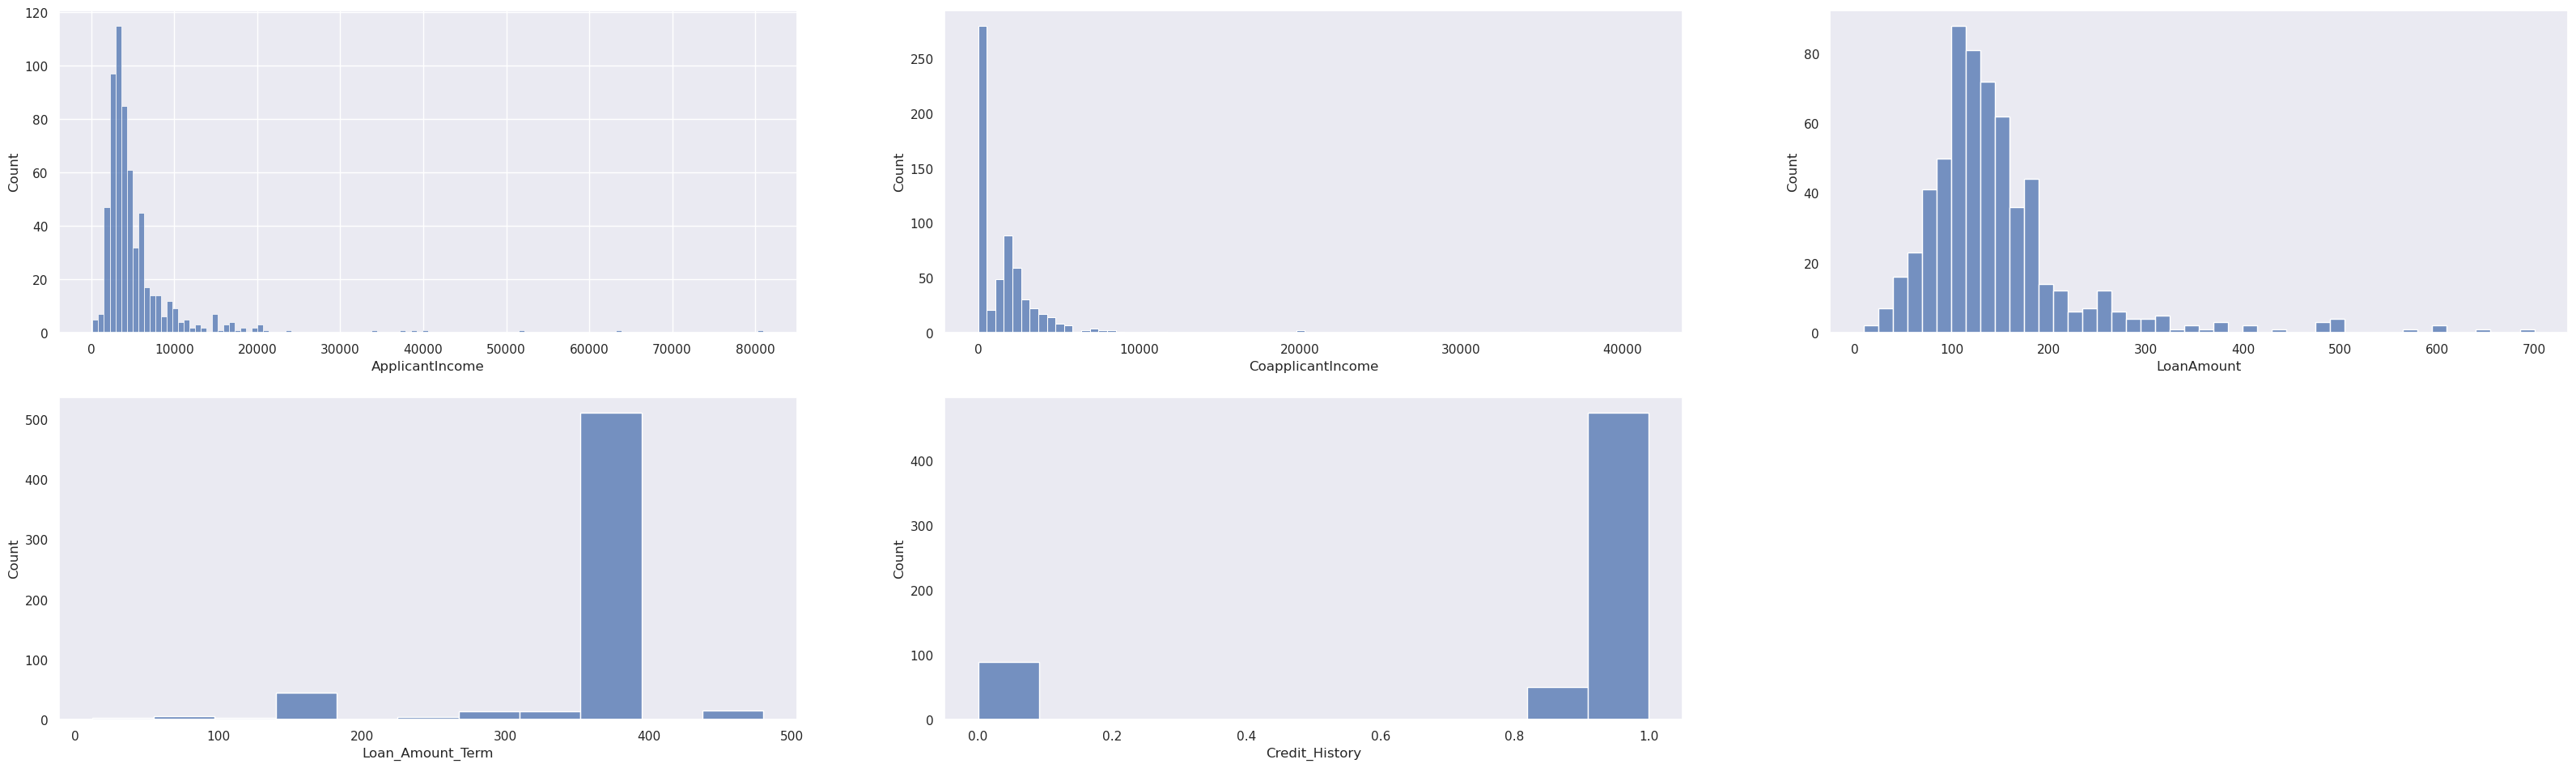

In [25]:
plt.figure(figsize=(40,30))
for i,col in enumerate(numeric_col):
    plt.subplot(5,3,i+1)
    sns.set_style('dark')
    sns.histplot(train[col])
plt.show()

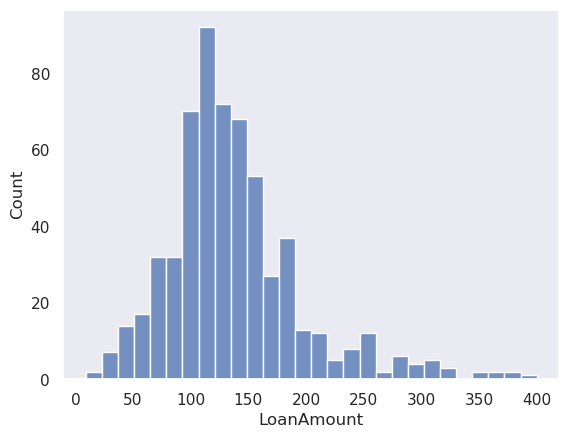

In [26]:
train.drop(train['LoanAmount'][train['LoanAmount']>400].index, inplace=True)
sns.histplot(train['LoanAmount'])
plt.show()

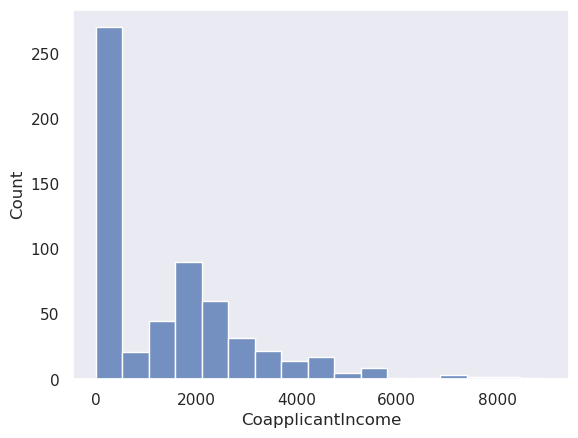

In [27]:
train.drop(train['CoapplicantIncome'][train['CoapplicantIncome']>10000].index, inplace=True)
sns.histplot(train['CoapplicantIncome'])
plt.show()

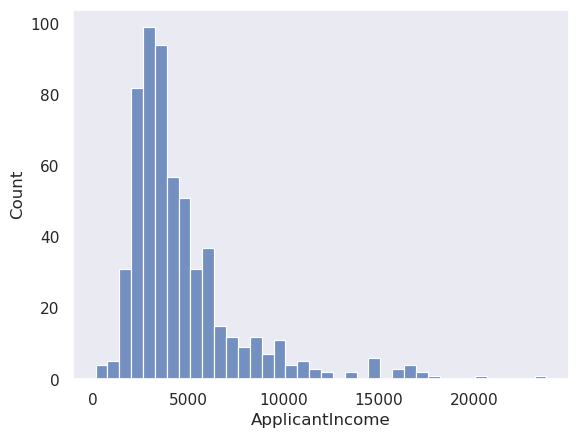

In [28]:
train.drop(train['ApplicantIncome'][train['ApplicantIncome']>25000].index, inplace=True)
sns.histplot(train['ApplicantIncome'])
plt.show()

# Treating object data types for model building

In [29]:
#Chekcing the remaining columns to treat the object data types
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            591 non-null    object 
 1   Gender             591 non-null    object 
 2   Married            591 non-null    object 
 3   Dependents         591 non-null    object 
 4   Education          591 non-null    object 
 5   Self_Employed      591 non-null    object 
 6   ApplicantIncome    591 non-null    int64  
 7   CoapplicantIncome  591 non-null    float64
 8   LoanAmount         591 non-null    float64
 9   Loan_Amount_Term   591 non-null    float64
 10  Credit_History     591 non-null    float64
 11  Property_Area      591 non-null    object 
 12  Loan_Status        591 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 64.6+ KB


In [31]:
#Converting dependents into int as it includes integer values
train['Dependents']=train['Dependents'].astype('int')

In [32]:
#Mapping the object columns to convert it into binary from and then change the data type to int
train['Married']=train['Married'].map({'Yes':1, 'No':0})
train['Education']=train['Education'].map({'Graduate':1, 'Not Graduate':0})
train['Self_Employed']=train['Self_Employed'].map({'Yes':1, 'No':0})
train['Loan_Status']=train['Loan_Status'].map({'Y':1, 'N':0})

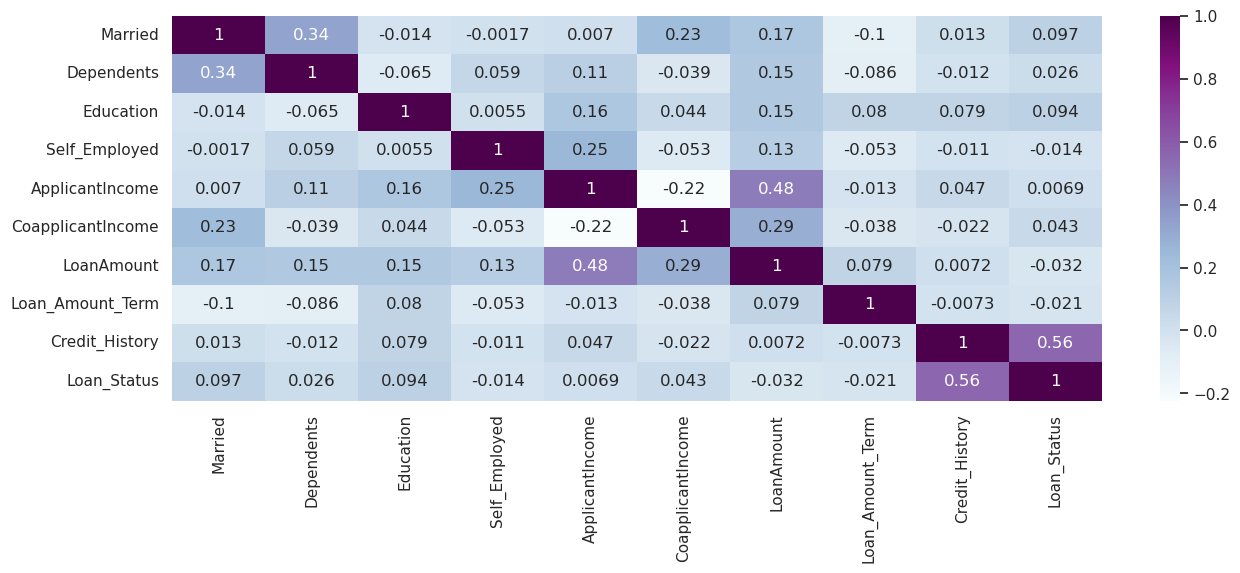

In [33]:
#Checking for correlation
plt.figure(figsize=(15,5))
sns.heatmap(train.corr(),cmap='BuPu',annot=True)
plt.show()

* Loan status is highly correlated to Credit history
* we can see some multicoreniality - for eg- applicant income is highly correlated to loan amount

# Dropping redundant columns

In [34]:
train.drop('Loan_ID',axis=1, inplace=True)

In [35]:
#Using get dummies for the remaining object columns for which mapping or encoder cant be used 
train=pd.get_dummies(train)
train.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,1,0,5849,0.0,146.41,360.0,1.0,1,0,1,0,0,1
1,1,1,1,0,4583,1508.0,128.00,360.0,1.0,0,0,1,1,0,0
2,1,0,1,1,3000,0.0,66.00,360.0,1.0,1,0,1,0,0,1
3,1,0,0,0,2583,2358.0,120.00,360.0,1.0,1,0,1,0,0,1
4,0,0,1,0,6000,0.0,141.00,360.0,1.0,1,0,1,0,0,1


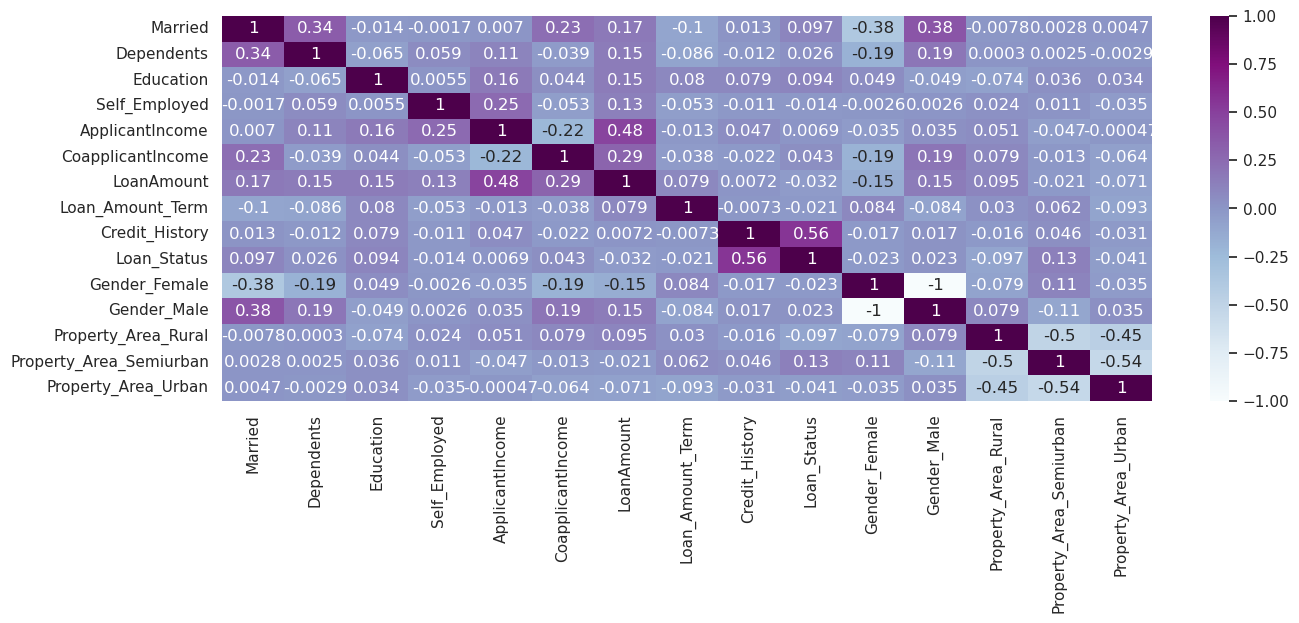

In [36]:
#Checking for correlation again now that we have treated the object columns
plt.figure(figsize=(15,5))
sns.heatmap(train.corr(),cmap='BuPu',annot=True)
plt.show()

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 613
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  591 non-null    int64  
 1   Dependents               591 non-null    int64  
 2   Education                591 non-null    int64  
 3   Self_Employed            591 non-null    int64  
 4   ApplicantIncome          591 non-null    int64  
 5   CoapplicantIncome        591 non-null    float64
 6   LoanAmount               591 non-null    float64
 7   Loan_Amount_Term         591 non-null    float64
 8   Credit_History           591 non-null    float64
 9   Loan_Status              591 non-null    int64  
 10  Gender_Female            591 non-null    uint8  
 11  Gender_Male              591 non-null    uint8  
 12  Property_Area_Rural      591 non-null    uint8  
 13  Property_Area_Semiurban  591 non-null    uint8  
 14  Property_Area_Urban      5

Finally all the object columns are treated and there are no null values in our data so we can start working on model building

# Model building

In [38]:
#Spliting the dataset into features and target
x=train.drop('Loan_Status',axis=1)
y=train['Loan_Status']

In [39]:
#Further splitting the dataset into training and testing data
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.25,stratify=y)

In [40]:
#Using logistic regression supervised ML classification model
lr=LogisticRegression()
lr.fit(xtrain,ytrain)

LogisticRegression()

In [41]:
ypred=lr.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

0.8243243243243243
[[ 22  24]
 [  2 100]]
              precision    recall  f1-score   support

           0       0.92      0.48      0.63        46
           1       0.81      0.98      0.88       102

    accuracy                           0.82       148
   macro avg       0.86      0.73      0.76       148
weighted avg       0.84      0.82      0.81       148



# Stratified K-Folds

In [42]:
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
i=1
for train_index,test_index in kf.split(x,y):
    global model
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=x.iloc[train_index],x.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]    
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('Accuracy score: ', score)
    i+=1
    pred_test =model.predict(xtest)
    pred= model.predict_proba(xvl)[:,1]
    
   

1 of kfold 5
Accuracy score:  0.7983193277310925
2 of kfold 5
Accuracy score:  0.7966101694915254
3 of kfold 5
Accuracy score:  0.8135593220338984
4 of kfold 5
Accuracy score:  0.7966101694915254
5 of kfold 5
Accuracy score:  0.8305084745762712


# ROC-AUC Curve 

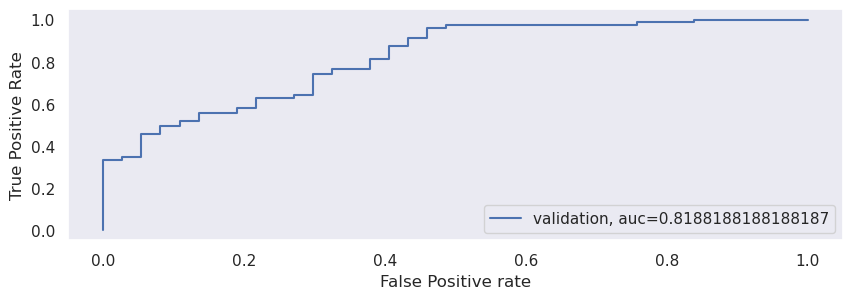

In [43]:
fpr,tpr,_=metrics.roc_curve(yvl,pred)
auc=metrics.roc_auc_score(yvl,pred)
plt.figure(figsize=(10,3))
plt.plot(fpr,tpr,label='validation, auc='+str(auc))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')   
plt.legend(loc=4)
plt.show()

# Submission

In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [45]:
test['Gender'].fillna(test['Gender'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0],inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].mean(),inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mean(),inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mean(),inplace=True)

In [46]:
test['Dependents']=test['Dependents'].replace('3+',3)
test['Dependents']=test['Dependents'].astype(int)

In [47]:
test.drop('Loan_ID',axis=1, inplace=True)
test['Married']=test['Married'].map({'Yes':1, 'No':0})
test['Self_Employed']=test['Self_Employed'].map({'Yes':1, 'No':0})
test['Education']=test['Education'].map({'Graduate':1, 'Not Graduate':0})

In [48]:
test=pd.get_dummies(test)
test.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,1,0,5720,0,110.0,360.0,1.000000,0,1,0,0,1
1,1,1,1,0,3076,1500,126.0,360.0,1.000000,0,1,0,0,1
2,1,2,1,0,5000,1800,208.0,360.0,1.000000,0,1,0,0,1
3,1,2,1,0,2340,2546,100.0,360.0,0.825444,0,1,0,0,1
4,0,0,0,0,3276,0,78.0,360.0,1.000000,0,1,0,0,1


In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  367 non-null    int64  
 1   Dependents               367 non-null    int64  
 2   Education                367 non-null    int64  
 3   Self_Employed            367 non-null    int64  
 4   ApplicantIncome          367 non-null    int64  
 5   CoapplicantIncome        367 non-null    int64  
 6   LoanAmount               367 non-null    float64
 7   Loan_Amount_Term         367 non-null    float64
 8   Credit_History           367 non-null    float64
 9   Gender_Female            367 non-null    uint8  
 10  Gender_Male              367 non-null    uint8  
 11  Property_Area_Rural      367 non-null    uint8  
 12  Property_Area_Semiurban  367 non-null    uint8  
 13  Property_Area_Urban      367 non-null    uint8  
dtypes: float64(3), int64(6), u

In [50]:
pred_test=model.predict(test)

In [51]:
submission=pd.DataFrame()
submission['Loan_ID']=test_og['Loan_ID']
submission['Loan_Status']=pred_test

In [52]:
submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes', 2: 'No'})

In [53]:
pd.DataFrame(submission, columns=['Loan_ID', 'Loan_Status']).to_csv('Logistic_Regression.csv')

In [54]:
train.columns

Index(['Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Female',
       'Gender_Male', 'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

# Feature Engineering

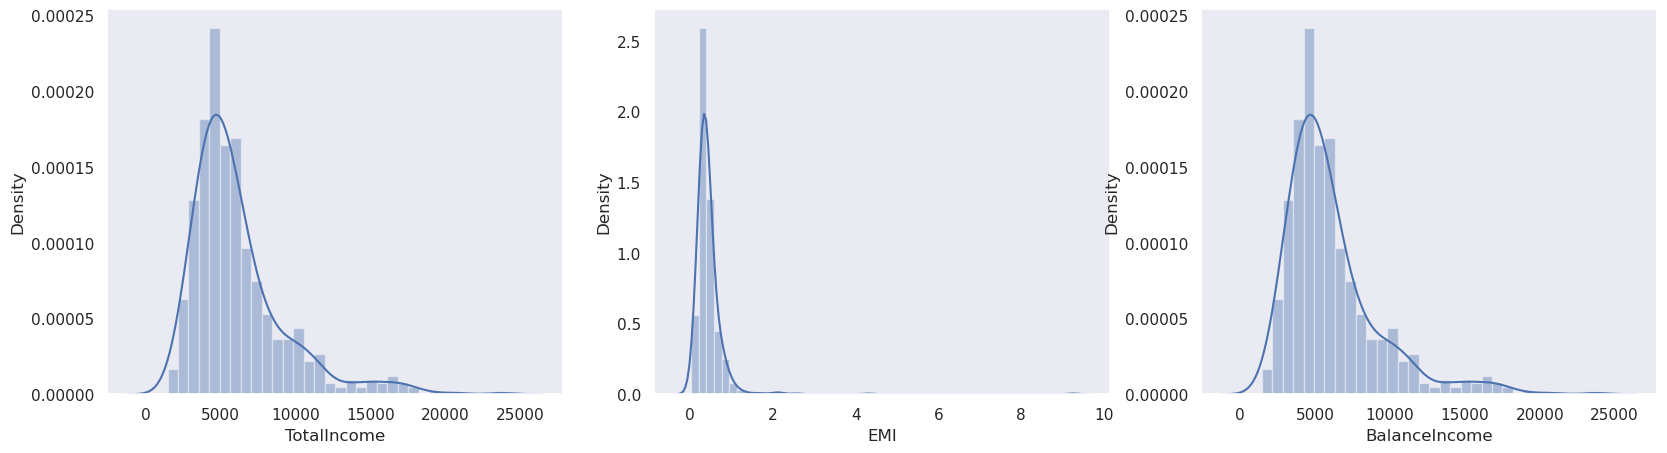

In [55]:
train['TotalIncome']=train['ApplicantIncome']+train['CoapplicantIncome']
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term']
train['BalanceIncome']=train['TotalIncome']-train['EMI']

plt.figure(1,figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(train['TotalIncome'])
plt.subplot(1,3,2)
sns.distplot(train['EMI'])
plt.subplot(1,3,3)
sns.distplot(train['BalanceIncome'])
plt.show()

In [56]:
test['TotalIncome']=test['ApplicantIncome']+test['CoapplicantIncome']
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']
test['BalanceIncome']=test['TotalIncome']-test['EMI']

In [57]:
train.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)
test.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)


# Testing multiple models

In [58]:
x=train.drop('Loan_Status', axis=1)
y=train['Loan_Status']

In [59]:
def model(model_name,feature,target):
    i=1
    kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    for train_index,test_index in kf.split(x,y):
        print('{} of kfold {}'.format(i,kf.n_splits))
        xtr,xte= x.iloc[train_index],x.iloc[test_index]
        ytr,yte=y.iloc[train_index],y.iloc[test_index]
        
        model=model_name
        model.fit(xtr,ytr)
        pred=model.predict(xte)
        score=accuracy_score(yte,pred)
        print('Accuracy_score: ',score)
        i+=1
        pred_test=model.predict(test)
        pred=model.predict_proba(xte)[:,1]
    

In [60]:
model(LogisticRegression(),x,y)

1 of kfold 5
Accuracy_score:  0.8235294117647058
2 of kfold 5
Accuracy_score:  0.7966101694915254
3 of kfold 5
Accuracy_score:  0.8220338983050848
4 of kfold 5
Accuracy_score:  0.8135593220338984
5 of kfold 5
Accuracy_score:  0.8135593220338984


In [61]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('LogisticRegression2.csv')

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
dt=DecisionTreeClassifier()

In [63]:
model(dt,x,y)

1 of kfold 5
Accuracy_score:  0.7394957983193278
2 of kfold 5
Accuracy_score:  0.6694915254237288
3 of kfold 5
Accuracy_score:  0.7542372881355932
4 of kfold 5
Accuracy_score:  0.7288135593220338
5 of kfold 5
Accuracy_score:  0.7457627118644068


In [64]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('DecisionTreeClassifier.csv')

In [65]:
model(RandomForestClassifier(max_depth=10, random_state=2),x,y)

1 of kfold 5
Accuracy_score:  0.8067226890756303
2 of kfold 5
Accuracy_score:  0.788135593220339
3 of kfold 5
Accuracy_score:  0.8135593220338984
4 of kfold 5
Accuracy_score:  0.7966101694915254
5 of kfold 5
Accuracy_score:  0.8220338983050848


# GridSearchCV

In [66]:
parameters={'max_depth':list(range(1,20,2)),'n_estimators': list(range(1,200,20))}
grid=GridSearchCV(RandomForestClassifier(random_state=1), parameters)

xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=1,test_size=0.25)
grid.fit(xtrain,ytrain)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161,
                                          181]})

In [67]:
grid.best_params_
grid.best_score_
print(grid.best_estimator_)
model=grid.best_estimator_
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)

RandomForestClassifier(max_depth=5, n_estimators=21, random_state=1)


In [68]:
rfc=RandomForestClassifier(max_depth=5,n_estimators=21 ,random_state=1)
rfc.fit(xtrain,ytrain)
ypred=rfc.predict(xtest)

In [69]:
pred_test=rfc.predict(test)

In [70]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('RandomForestClassifier.csv')

# Feature Importance

<Axes: >

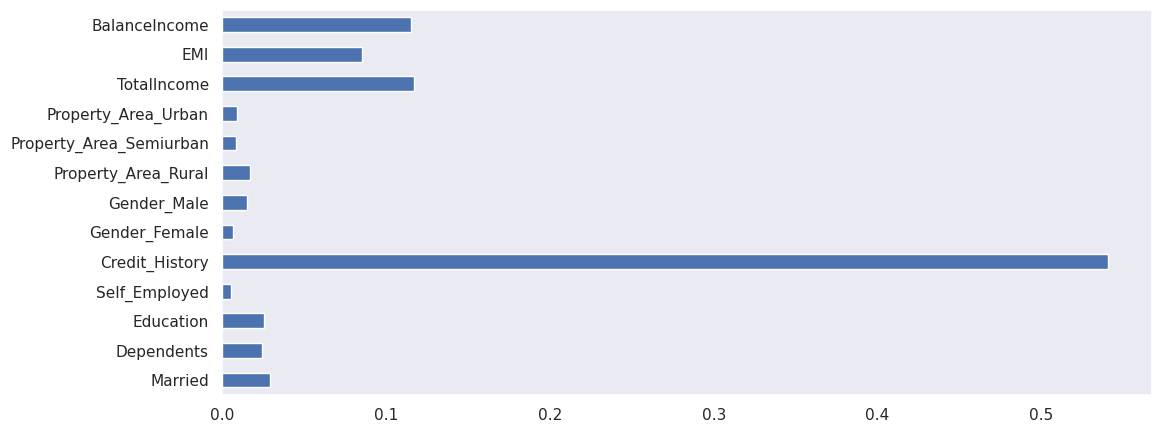

In [71]:
importances=pd.Series(rfc.feature_importances_, index=x.columns)
importances.plot(kind='barh',figsize=(12,5))

# XGB CLassifier

In [72]:
i=1
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
for train_index,test_index in kf.split(x,y):
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xte= x.iloc[train_index],x.iloc[test_index]
    ytr,yte=y.iloc[train_index],y.iloc[test_index]
        
    model=XGBClassifier()
    model.fit(xtr,ytr)
    pred=model.predict(xte)
    score=accuracy_score(yte,pred)
    print('Accuracy_score: ',score)
    i+=1
    pred_test=model.predict(test)
    pred=model.predict_proba(xte)[:,1]

1 of kfold 5
Accuracy_score:  0.7983193277310925
2 of kfold 5
Accuracy_score:  0.6694915254237288
3 of kfold 5
Accuracy_score:  0.8050847457627118
4 of kfold 5
Accuracy_score:  0.7288135593220338
5 of kfold 5
Accuracy_score:  0.7796610169491526


In [73]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']

submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',2:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('XGBClassifier.csv')

# Thankyou :)